***
# Solution: Topic Modeling
***




*By Asmik Nalmpatian and Lisa Wimmer – for Intro to NLP*

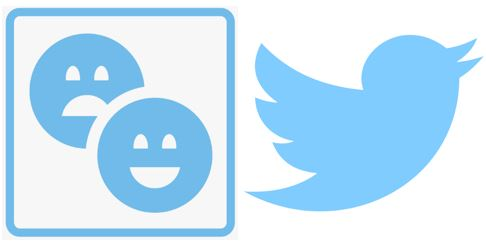

## Set-up

Check: `Runtime type = R`?

➡ If not, re-launch Google Colab via https://colab.to/r and upload this notebook there.



## Packages

In [ ]:
# Install all required packages

install.packages("data.table")
install.packages("ggplot2")
install.packages("quanteda")
install.packages("stm")
install.packages("wordcloud")

In [ ]:
# Load all required packages

library(data.table)
library(ggplot2)
library(quanteda)
library(stm)
library(wordcloud)

## Data

1. On the left command pane, move to the `Files` section.
2. Select 'Upload to the session storage'.
3. Upload the `articles.RDS` data from the course website (the data will vanish as soon as you terminate the colab session).

In [ ]:
articles <- readRDS("articles.RDS")
quanteda::docvars(articles)$text <- quanteda::texts(articles)

str(articles)

## Exercise 1: Create `dfm`

We have acquired a corpus of blogpost articles from [Medium](https://medium.com) via [Kaggle](https://www.kaggle.com/hsankesara/medium-articles?select=articles.csv) (enriched with two synthesized variables, `country` and `source`) and would like to find out what they are about, so we decide to fit a structural topic model (STM).

In the first step, convert the data into a `dfm` object (as the texts are in English this time we need not worry about umlauts this time; in fact, there are no relevant special characters in the text at all).

1. Tokenize the corpus, including stemming and stopwords removal. For stopwords, you can use `stopwords::stopwords("en", source = "stopwords-iso")` (*Hint*: you can simply use built-in functionalities here, you don't need to bother with customized stopwords etc. or with keeping only capitalized words -- this stuff is a bit easier in English-language texts. If you find it necessary to choose a more individual approach, though, you are of course free to do so).
2. Convert the `tokens` to a `dfm` object. If you consider it appropriate, constrain to a certain amount of features. 

*Solution*

In [4]:
# Tokenize articles corpus

articles_tokens <- quanteda::tokens(
  articles,
  what = "word",
  remove_symbols = TRUE,
  remove_punct = TRUE,
  remove_numbers = TRUE,
  remove_separators = TRUE,
  split_hyphens = TRUE,
  include_docvars = TRUE)

articles_tokens <- quanteda::tokens_wordstem(
  articles_tokens, 
  language = "english")

articles_tokens <- quanteda::tokens_tolower(articles_tokens)

articles_tokens <- quanteda::tokens_remove(
  articles_tokens,
  pattern = stopwords::stopwords("en", source = "stopwords-iso"))

In [ ]:
# Convert to dfm

articles_dfm <- quanteda::dfm(articles_tokens)

# Optionally, remove less common features

articles_dfm <- quanteda::dfm_select(
  articles_dfm,
  names(quanteda::topfeatures(articles_dfm, n = 500)))

# Inspect 

articles_dfm

## Exercise 2: Create `stm`

Now convert your `dfm` into an `stm` object:

1. Define the prevalence formula. You should include
* the number of claps `claps` (as a smooth effect with 3 degrees of freedom),
* reading time in minutes `reading_time` (as a smooth effect with 3 degrees of freedom),
* the author's country of origin `country`, and
* the source type `source`.
2. Make sure there are no missing values in any of the covariates.
3. Define the `stm` object.

*Solution*


In [6]:
# Define prevalence formula

prevalence_formula <- as.formula(paste(
  "", 
  "s(claps, df = 3) + s(reading_time, df = 3) + country + source", 
  sep = "~"))

In [ ]:
# Check for incomplete cases and remove if any are present

articles_dfm <- quanteda::dfm_subset(
  articles_dfm,
  !is.na(claps) & !is.na(reading_time) & !is.na(country) &
    !is.na(source))

articles_dfm # seems we did not have any missings

In [ ]:
# Create stm object

articles_stm <- quanteda::convert(articles_dfm, to = "stm")

summary(articles_stm)

## Exercise 3: Fit STM

Modeling time! 

1. Conduct a search for the optimal number of topics first, specifying a search range $K \in [3, 7]$. As a goodness-of-fit measure, consider both semantic coherence and exclusivity, i.e., find the $K$ that balances these two goals best (think about / check whether we prefer high or low values in this regard). In case of ties, go for the lowest-possible number of topics. 
2. Afterwards, compute the model. Make sure the process is allowed a sufficient number of iterations and feel free to play around with the gamma prior and the initialization type.

*Solution*

In [ ]:
# Search for optimal K

hyperparameter_search <- stm::searchK(
  documents = articles_stm$documents,
  vocab = articles_stm$vocab,
  data = articles_stm$meta,
  K = c(3:7),
  prevalence = prevalence_formula,
  heldout.seed = 1,
  max.em.its = 10,
  init.type = "LDA")

In [ ]:
# Inspect

hyperparameter_search$results

In [ ]:
# Determine optimal K

hyperparameter_search$results$rank_exclus <- 
  rev(order(unlist(hyperparameter_search$results$exclus)))
hyperparameter_search$results$rank_semcoh <- 
  rev(order(unlist(hyperparameter_search$results$semcoh)))
hyperparameter_search$results$rank_semcoh_exclus <-
  0.5 * (hyperparameter_search$results$rank_semcoh + 
    hyperparameter_search$results$rank_exclus)

hyperparameter_search$results  

In [ ]:
# Set K dynamically

n_topics <- as.numeric(hyperparameter_search$results[
  which.min(hyperparameter_search$results$rank_semcoh_exclus), "K"])

n_topics

In [ ]:
# Fit STM

topic_model <- stm::stm(
    documents = articles_stm$documents,
    vocab = articles_stm$vocab,
    data = articles_stm$meta,
    K = n_topics,
    prevalence = prevalence_formula,
    gamma.prior = "L1",
    seed = 1,
    max.em.its = 15,
    init.type = "LDA")

## Exercise 4: Interpret Model Output

And now for the most delicate part of the modeling process.

Inspect and interpret the model output with your methods of choice. Can you identify some meaningful topics in our blogposts?

*Solution*

In [ ]:
# Check out most important words per topic

stm::labelTopics(topic_model, n = 20)

In [ ]:
# Visualize topic proportion with most important word

plot(topic_model, type = "summary")

In [ ]:
# Print word clouds

invisible(lapply(
  seq_len(n_topics), 
  function(i) stm::cloud(topic_model, topic = i)))

In [ ]:
# Print most representative documents per topic
# (For shorter texts, you can also check stm::plotQuote)

thoughts <- lapply(seq_len(n_topics), function(i) {
  stm::findThoughts(
    model = topic_model,
    texts = articles_stm$meta$text,
    topics = i,
    n = 2)$docs[[1]]})

thoughts

Again, it's not easy to identify clear-cut topics. Perhaps topic 2 is mostly concerned with deep neural networks, and topic 4 could be roughly about artificial intelligence.

## Exercise 5: Assign Topics to Documents

Lastly, inject the topic info back into our corpus.

1. Create a new data table containing the topic probabilities for each document based upon which you can assign each document its topic label.
2. Visualize the topic label distribution across documents by an appropriate plot.

*Solution*

In [ ]:
# Compute topic probabilities

topic_probs <- stm::make.dt(topic_model)[
  , doc_id := names(articles_stm$documents)
  ][, docnum := NULL]

topic_probs[sample(topic_probs[, .I], 5)]

In [19]:
# Compute topic labels

topic_cols <- names(topic_probs)[startsWith(names(topic_probs), "Topic")]

topic_probs[
  , `:=` (
    max_topic_score = max(.SD, na.rm = TRUE),
    topic_label = which.max(.SD)),
  .SDcols = topic_cols,
  by = doc_id]

In [ ]:
# Visualize

ggplot2::ggplot(topic_probs, aes(x = topic_label)) +
  geom_bar() + 
  xlab("Topic") +
  ylab("Document count")